In [119]:
import psycopg2
import pandas as pd
import os
import datetime as dt
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, RocCurveDisplay
import script as sc
import statsmodels.api as sm

In [2]:
def make_csv(query, filename):
   
    # check if file already exists
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        return df
    # ensure all columns are displayed when viewing a pandas dataframe
    pd.set_option('display.max_columns', None)
    
    # Creating a connection to the database
    print("creating connection...")
    con = psycopg2.connect(database="mid_term_project", 
                           user="lhl_student", 
                           password="lhl_student", 
                           host="lhl-data-bootcamp.crzjul5qln0e.ca-central-1.rds.amazonaws.com", 
                           port="5432")


    # creating a cursor object
    cur = con.cursor()
    # running an sql query
    print("running query...")
    cur.execute(query)
    # Storing the result
    rows = cur.fetchall()
    cols = [desc[0] for desc in cur.description]

    con.close()

    # writing the csv file
    print("writing file...")
    df = pd.DataFrame(rows, columns=cols)
    df.to_csv(filename, index=False)
    
    print('Done')
    
    return df

In [3]:
def unique_values(df):
    for i in range(len(df.columns)):
        unique =  df.iloc[:, i].unique()
        print(i, unique)
    return

In [4]:
def date_to_dtday(df, feature, form = 'day'):
    '''
    set date column to either binary or datetime numeric 
    '''
    df[feature] =  pd.to_datetime(test['fl_date'], format='%Y-%m-%d')
    df[feature] = df[feature].dt.day_of_week
    if form == 'binary':
        df.loc[df[feature] <= 4, feature] = 0
        df.loc[df[feature] > 4, feature] = 1
    return df

In [5]:
def replace_with_numeric(df, column):
    '''
    input the data frame and the column to repalace the unique values with numeric values
    '''
    unique_vals = df[column].unique()
    df[column].replace(to_replace=unique_vals,
                                  value= list(range(len(unique_vals))),
                                  inplace=True)
    return

In [43]:
test = make_csv("SELECT * FROM flights LIMIT 1000000", "test1000000flight.csv")

creating connection...
running query...
writing file...
Done


In [51]:
test.head()

,fl_date,op_carrier_fl_num,origin_airport_id,dest_airport_id,taxi_out,wheels_off,wheels_on,taxi_in,diverted,air_time,distance,total_delay
0,2018-07-20,471,11259,13198,10.0,716.0,826.0,5.0,0.0,70.0,460.0,1
1,2018-07-20,616,11259,13198,14.0,2303.0,36.0,6.0,0.0,93.0,460.0,0
2,2018-07-20,2130,11259,13198,9.0,1128.0,1238.0,5.0,0.0,70.0,460.0,0
3,2018-07-20,2287,11259,13198,8.0,1854.0,2005.0,4.0,0.0,71.0,460.0,1
4,2018-07-20,2371,11259,13198,9.0,824.0,934.0,5.0,0.0,70.0,460.0,0


In [45]:
test['crs_dep_time'] = test['crs_dep_time'].astype('float64')
test['crs_arr_time'] = test['crs_arr_time'].astype('float64')

In [46]:
test['total_delay'] = (test['dep_time'] - test['crs_dep_time']) + (test['arr_time'] - test['crs_arr_time']) + (test['actual_elapsed_time'] - test['crs_elapsed_time'])

In [47]:
test = test.drop(['dep_delay', 'arr_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'carrier_delay', 'weather_delay', 'no_name', 'mkt_carrier', 'branded_code_share', 'origin_city_name', 'origin', 'dest', 'dest_city_name', 'dep_time', 'crs_dep_time', 'arr_time', 'crs_arr_time', 'actual_elapsed_time', 'crs_elapsed_time', 'dup', 'cancelled', 'cancellation_code', 'flights', 'first_dep_time', 'total_add_gtime', 'longest_add_gtime', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'tail_num', 'op_unique_carrier'], axis = 1)

In [50]:
test['total_delay'] = test['total_delay'].apply(lambda x: 0 if x < 0 else 1)

In [49]:
test = test.dropna()

In [52]:
test = date_to_dtday(test, 'fl_date', 'binary')

In [42]:
test.tail()

,fl_date,op_carrier_fl_num,origin_airport_id,dest_airport_id,taxi_out,wheels_off,wheels_on,taxi_in,diverted,air_time,distance,total_delay
999995,0,1071,10397,13495,10.0,1805.0,1815.0,4.0,0.0,70.0,425.0,1
999996,0,1208,10397,13495,18.0,2048.0,2059.0,4.0,0.0,71.0,425.0,1
999997,0,264,10397,13796,13.0,1555.0,1755.0,5.0,0.0,300.0,2130.0,1
999998,0,163,10397,14027,9.0,2112.0,2233.0,3.0,0.0,81.0,545.0,1
999999,0,2108,10397,14027,18.0,1059.0,1227.0,5.0,0.0,88.0,545.0,1


In [101]:
y_col = 'total_delay'
y = test[y_col]
X = test[test.columns.drop(y_col)]

In [94]:
#sc.split_data(test, 'total_delay', scaler = 'standard')


No columns dropped.

Target values: [1 0 0 ... 0 0 1] 

Column(s) remaining: Index(['fl_date', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'diverted',
       'air_time', 'distance', 'total_delay'],
      dtype='object')

training sample size:  780177
testing sample size:  195045


(array([[-0.57445725,  1.15649042,  1.56634299, ...,  0.        ,
         -0.94544473, -1.09655903],
        [-0.57445725, -0.26734716,  0.3420244 , ...,  0.        ,
         -1.01699213, -1.01155482],
        [-0.57445725, -0.74051929,  1.30980035, ...,  0.        ,
         -0.84527838, -0.79564414],
        ...,
        [-0.57445725,  0.66873422, -0.90853897, ...,  0.        ,
         -1.11715848, -1.04385642],
        [ 1.74077357,  0.8513052 ,  0.92990728, ...,  0.        ,
         -0.22997079, -0.18021369],
        [-0.57445725, -0.59899977,  0.17733846, ...,  0.        ,
          0.42826523,  0.3026102 ]]),
 array([[ 1.74077357, -1.39518209, -0.18418327, ...,  0.        ,
         -1.16008691, -1.10675953],
        [ 1.74077357,  0.51803214,  0.53295511, ...,  0.        ,
         -0.40168454, -0.37572336],
        [-0.57445725,  0.61958049, -1.36716635, ...,  0.        ,
         -0.18704236, -0.18871411],
        ...,
        [-0.57445725, -1.36385334,  0.93450012, ...,  

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [115]:
clf = LogisticRegression(penalty = 'l2', max_iter = 1000)

clf.fit(X, y)

LogisticRegression(max_iter=1000)

In [116]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6906178755635461


In [117]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78    183264
           1       0.65      0.38      0.48    109303

    accuracy                           0.69    292567
   macro avg       0.67      0.63      0.63    292567
weighted avg       0.68      0.69      0.67    292567



In [109]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7920134533286393


In [110]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85    183264
           1       0.80      0.59      0.68    109303

    accuracy                           0.79    292567
   macro avg       0.79      0.75      0.76    292567
weighted avg       0.79      0.79      0.78    292567



In [112]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %f' % (rmse))

RMSE: 0.456055


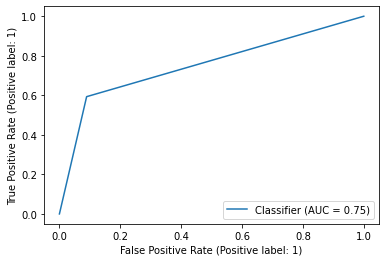

In [113]:
RocCurveDisplay.from_predictions(y_test, y_pred)

In [118]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[160614  22650]
 [ 67865  41438]]


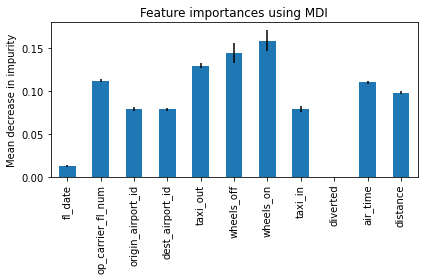

In [85]:
import time
import numpy as np

start_time = time.time()
feature_names = [test.columns[i] for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [86]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 1076.872 seconds


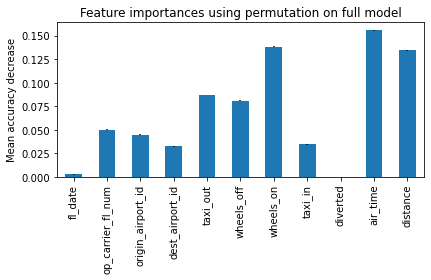

In [87]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [297]:
testl = pd.read_csv('test1000000linflight.csv')

In [298]:
testl['crs_dep_time'] = testl['crs_dep_time'].astype('float64')
testl['crs_arr_time'] = testl['crs_arr_time'].astype('float64')

In [299]:
testl['total_delay'] = (testl['dep_time'] - testl['crs_dep_time']) + (testl['arr_time'] - testl['crs_arr_time']) + (testl['actual_elapsed_time'] - testl['crs_elapsed_time'])

In [300]:
testl = testl.drop(['dep_delay', 'arr_delay', 'nas_delay', 'diverted', 'security_delay', 'late_aircraft_delay', 'carrier_delay', 'weather_delay', 'no_name', 'mkt_carrier', 'branded_code_share', 'origin_city_name', 'origin', 'dest', 'dest_city_name', 'dep_time', 'crs_dep_time', 'arr_time', 'crs_arr_time', 'actual_elapsed_time', 'crs_elapsed_time', 'dup', 'cancelled', 'cancellation_code', 'flights', 'first_dep_time', 'total_add_gtime', 'longest_add_gtime', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'tail_num', 'op_unique_carrier'], axis = 1)

In [302]:
testl = date_to_dtday(testl, 'fl_date', 'binary')

TypeError: Invalid comparison between dtype=datetime64[ns] and int

In [ ]:
testday = testl['fl_date']
testl['fl_date'] = testday.astype('int64')

In [303]:
testl['fl_date'] =  pd.to_datetime(testl['fl_date'], format='%Y-%m-%d')
testl['fl_date'] =  testl['fl_date'].dt.day_of_week
testl.loc[testl['fl_date'] <= 4, 'fl_date'] = 0
testl.loc[testl['fl_date'] > 4, 'fl_date'] = 1

In [304]:
testl = testl.dropna()

In [305]:
testl.isna().sum()

fl_date              0
op_carrier_fl_num    0
origin_airport_id    0
dest_airport_id      0
taxi_out             0
wheels_off           0
wheels_on            0
taxi_in              0
air_time             0
distance             0
total_delay          0
dtype: int64

In [306]:
y_coll = 'total_delay'
yl = testl[y_coll]
Xl = testl[testl.columns.drop(y_coll)]

In [307]:
Xl = sm.add_constant(Xl)

model = sm.OLS(yl, Xl).fit()
predictinos = model.predict(Xl)
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            total_delay   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                 1.260e+04
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        17:59:55   Log-Likelihood:            -7.0515e+06
No. Observations:              984724   AIC:                         1.410e+07
Df Residuals:                  984713   BIC:                         1.410e+07
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -260.4770      3.92

# Weather addition

In [220]:
weath = pd.read_csv('weather.csv')

In [221]:
weath = weath.drop(['condition', 'Unnamed: 0'], axis = 1)

In [222]:
weath['date'] =  pd.to_datetime(weath['date'], format='%Y-%m-%d')

In [214]:
unique_values(weath)

0 ['Abilene, TX' 'Akron, OH' 'Albuquerque, NM' 'Amarillo, TX' 'Appleton, WI'
 'Asheville, NC' 'Aspen, CO' 'Atlanta, GA' 'Augusta, GA' 'Austin, TX'
 'Baltimore, MD' 'Bangor, ME' 'Baton Rouge, LA' 'Bellingham, WA'
 'Bend/Redmond, OR' 'Billings, MT' 'Birmingham, AL'
 'Bloomington/Normal, IL' 'Boston, MA' 'Bozeman, MT' 'Buffalo, NY'
 'Burbank, CA' 'Cape Girardeau, MO' 'Charleston, SC'
 'Charlotte Amalie, VI' 'Charlotte, NC' 'Chattanooga, TN' 'Chicago, IL'
 'Cincinnati, OH' 'Cleveland, OH' 'College Station/Bryan, TX'
 'Colorado Springs, CO' 'Columbia, MO' 'Columbia, SC' 'Columbus, GA'
 'Columbus, MS' 'Columbus, OH' 'Dallas, TX' 'Dallas/Fort Worth, TX'
 'Daytona Beach, FL' 'Deadhorse, AK' 'Del Rio, TX' 'Denver, CO'
 'Des Moines, IA' 'Detroit, MI' 'Durango, CO' 'El Paso, TX' 'Erie, PA'
 'Eugene, OR' 'Fargo, ND' 'Fayetteville, AR' 'Flint, MI'
 'Fort Lauderdale, FL' 'Fort Myers, FL' 'Fresno, CA' 'Gainesville, FL'
 'Grand Forks, ND' 'Grand Junction, CO' 'Grand Rapids, MI' 'Green Bay, WI'
 'Green

In [261]:
weath.rename(columns = {'location':'origin_city_name', 'date':'fl_date', 'day/night':'dep_time'}, inplace = True)

In [262]:
weath.head()

,origin_city_name,fl_date,dep_time,cond_desc
0,"Abilene, TX",2019-01-01,0,cloudy
1,"Abilene, TX",2019-01-01,1,cloudy
2,"Abilene, TX",2019-01-02,0,cloudy
3,"Abilene, TX",2019-01-02,1,cloudy
4,"Abilene, TX",2019-01-03,0,rain


In [224]:
weath.dtypes

location             object
date         datetime64[ns]
day/night             int64
cond_desc            object
dtype: object

In [254]:
t = make_csv("SELECT * FROM flights LIMIT 1000", "test1000flight.csv")

creating connection...
running query...
writing file...
Done


In [255]:
t['crs_dep_time'] = t['crs_dep_time'].astype('float64')
t['crs_arr_time'] = t['crs_arr_time'].astype('float64')
t['total_delay'] = (t['dep_time'] - t['crs_dep_time']) + (t['arr_time'] - t['crs_arr_time']) + (t['actual_elapsed_time'] - t['crs_elapsed_time'])
t = t.drop(['dep_delay', 'arr_delay', 'nas_delay', 'diverted', 'security_delay', 'late_aircraft_delay', 'carrier_delay', 'weather_delay', 'no_name', 'mkt_carrier', 'branded_code_share', 'origin', 'dest', 'dest_city_name', 'crs_dep_time', 'arr_time', 'crs_arr_time', 'actual_elapsed_time', 'crs_elapsed_time', 'dup', 'cancelled', 'cancellation_code', 'flights', 'first_dep_time', 'total_add_gtime', 'longest_add_gtime', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'tail_num', 'op_unique_carrier'], axis = 1)

In [257]:
time1 = t['dep_time'].between(600,1800).values
time2 = t['dep_time'].between(0,600).values
time3 = t['dep_time'].between(1800,2359).values
t.loc[time1, 'dep_time']=0
t.loc[time2, 'dep_time']=1
t.loc[time3, 'dep_time']=1

In [258]:
t

,fl_date,op_carrier_fl_num,origin_airport_id,origin_city_name,dest_airport_id,dep_time,taxi_out,wheels_off,wheels_on,taxi_in,air_time,distance,total_delay
0,2019-04-02,5772,13256,"Mission/McAllen/Edinburg, TX",11298,0.0,11.0,1322.0,1434.0,10.0,72.0,469.0,-10.0
1,2019-04-02,5775,14107,"Phoenix, AZ",13851,0.0,17.0,1224.0,1604.0,6.0,100.0,833.0,-16.0
2,2019-04-02,5776,11298,"Dallas/Fort Worth, TX",12191,0.0,15.0,857.0,940.0,2.0,43.0,247.0,-86.0
3,2019-04-02,5776,12191,"Houston, TX",11298,0.0,12.0,1034.0,1120.0,15.0,46.0,247.0,-30.0
4,2019-04-02,5777,14689,"Santa Barbara, CA",14107,0.0,11.0,616.0,718.0,5.0,62.0,455.0,-52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2019-04-02,404,12266,"Houston, TX",14771,0.0,17.0,740.0,918.0,5.0,218.0,1635.0,-24.0
996,2019-04-02,403,11292,"Denver, CO",14908,0.0,13.0,935.0,1043.0,5.0,128.0,846.0,-2.0
997,2019-04-02,403,13930,"Chicago, IL",11292,0.0,12.0,641.0,753.0,6.0,132.0,888.0,-66.0
998,2019-04-02,402,14100,"Philadelphia, PA",13930,1.0,23.0,1849.0,1937.0,11.0,108.0,678.0,-86.0


In [259]:
t['fl_date'] =  pd.to_datetime(t['fl_date'], format='%Y-%m-%d')

In [260]:
t.dtypes

fl_date              datetime64[ns]
op_carrier_fl_num             int64
origin_airport_id             int64
origin_city_name             object
dest_airport_id               int64
dep_time                    float64
taxi_out                    float64
wheels_off                  float64
wheels_on                   float64
taxi_in                     float64
air_time                    float64
distance                    float64
total_delay                 float64
dtype: object

In [263]:
tweath = pd.merge(t, weath, on=['fl_date', 'origin_city_name', 'dep_time'], how='inner')
tweath.head()

,fl_date,op_carrier_fl_num,origin_airport_id,origin_city_name,dest_airport_id,dep_time,taxi_out,wheels_off,wheels_on,taxi_in,air_time,distance,total_delay,cond_desc
0,2019-04-02,5772,13256,"Mission/McAllen/Edinburg, TX",11298,0.0,11.0,1322.0,1434.0,10.0,72.0,469.0,-10.0,rain
1,2019-04-02,5775,14107,"Phoenix, AZ",13851,0.0,17.0,1224.0,1604.0,6.0,100.0,833.0,-16.0,rain
2,2019-04-02,5782,14107,"Phoenix, AZ",13244,0.0,34.0,920.0,1349.0,5.0,149.0,1264.0,18.0,rain
3,2019-04-02,5785,14107,"Phoenix, AZ",14570,0.0,14.0,1413.0,1539.0,3.0,86.0,601.0,28.0,rain
4,2019-04-02,5792,14107,"Phoenix, AZ",13891,0.0,17.0,750.0,844.0,5.0,54.0,325.0,-68.0,rain


In [264]:
mapping = {item:i for i, item in enumerate(tweath['cond_desc'].unique())}
tweath['weather_bin'] = tweath['cond_desc'].apply(lambda x: mapping[x])
tweath

,fl_date,op_carrier_fl_num,origin_airport_id,origin_city_name,dest_airport_id,dep_time,taxi_out,wheels_off,wheels_on,taxi_in,air_time,distance,total_delay,cond_desc,weather_bin
0,2019-04-02,5772,13256,"Mission/McAllen/Edinburg, TX",11298,0.0,11.0,1322.0,1434.0,10.0,72.0,469.0,-10.0,rain,0
1,2019-04-02,5775,14107,"Phoenix, AZ",13851,0.0,17.0,1224.0,1604.0,6.0,100.0,833.0,-16.0,rain,0
2,2019-04-02,5782,14107,"Phoenix, AZ",13244,0.0,34.0,920.0,1349.0,5.0,149.0,1264.0,18.0,rain,0
3,2019-04-02,5785,14107,"Phoenix, AZ",14570,0.0,14.0,1413.0,1539.0,3.0,86.0,601.0,28.0,rain,0
4,2019-04-02,5792,14107,"Phoenix, AZ",13891,0.0,17.0,750.0,844.0,5.0,54.0,325.0,-68.0,rain,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,2019-04-02,512,13495,"New Orleans, LA",12266,0.0,9.0,1415.0,1519.0,4.0,64.0,305.0,-2.0,rain,0
963,2019-04-02,430,13495,"New Orleans, LA",13930,0.0,9.0,1053.0,1259.0,3.0,126.0,836.0,-36.0,rain,0
964,2019-04-02,507,10620,"Billings, MT",11292,1.0,12.0,549.0,651.0,6.0,62.0,455.0,-76.0,cloudy,1
965,2019-04-02,491,10849,"Bozeman, MT",11292,0.0,30.0,845.0,1007.0,6.0,82.0,524.0,24.0,rain,0


In [267]:
tweath = tweath.drop(['origin_city_name', 'cond_desc'], axis = 1)

In [285]:
day = tweath['fl_date']
tweath['fl_date'] = day.astype('int64')

/var/folders/p7/h49crc791_s32gzljswx64y00000gn/T/ipykernel_37380/2804201127.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  tweath['fl_date'] = day.astype('int64')


In [288]:
tweath['fl_date'] =  pd.to_datetime(tweath['fl_date'], format='%Y-%m-%d')

In [289]:
tweath['fl_date'] =  tweath['fl_date'].dt.day_of_week

In [291]:
tweath.loc[tweath['fl_date'] <= 4, 'fl_date'] = 0
tweath.loc[tweath['fl_date'] > 4, 'fl_date'] = 1

In [292]:
tweath = tweath.dropna()

In [293]:
tweath.isna().sum()

fl_date              0
op_carrier_fl_num    0
origin_airport_id    0
dest_airport_id      0
dep_time             0
taxi_out             0
wheels_off           0
wheels_on            0
taxi_in              0
air_time             0
distance             0
total_delay          0
weather_bin          0
dtype: int64

In [294]:
tweath.dtypes

fl_date                int64
op_carrier_fl_num      int64
origin_airport_id      int64
dest_airport_id        int64
dep_time             float64
taxi_out             float64
wheels_off           float64
wheels_on            float64
taxi_in              float64
air_time             float64
distance             float64
total_delay          float64
weather_bin            int64
dtype: object

In [295]:
y_colw = 'total_delay'
yw = tweath[y_colw]
Xw = tweath[tweath.columns.drop(y_colw)]

In [296]:
Xw = sm.add_constant(Xw)

model = sm.OLS(yw, Xw).fit()
predictions = model.predict(Xw)
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            total_delay   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     10.22
Date:                Thu, 12 May 2022   Prob (F-statistic):           8.00e-18
Time:                        17:55:10   Log-Likelihood:                -6588.4
No. Observations:                 964   AIC:                         1.320e+04
Df Residuals:                     952   BIC:                         1.326e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -110.4191     95.62